Nguyễn Thiện Trí - 21522707

Đoàn Bảo Long - 21520332

# Library

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=1a487d2036aa94d97cb1201ed2b12caf513b43fb7fbd93dfbb1aa69ef3075641
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.sql.functions import lower
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import explode
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import NGram, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, LinearSVC, NaiveBayes, RandomForestClassifier, OneVsRest
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a SparkSession
spark = SparkSession.builder \
        .appName("MySparkApplication") \
        .config("spark.executor.memory", "64g")\
        .config("spark.driver.memory", "12g")\
        .getOrCreate()

# Importing Dataset

In [ ]:
# Define the path to the CSV file
csv_path = "/content/drive/MyDrive/DS200/ChatGPT_reviews.csv"

# read file
Data = spark.read.csv(csv_path, header=True, inferSchema=True)

# Drop the first column
Data = Data.drop("_c0")

# Rename columns 2 and 3
Data = Data.withColumnRenamed("tweets", "Text").withColumnRenamed("labels", "label")

# Convert values in the "label" column to numeric labels
Data = Data.withColumn("label", when(Data["label"] == "good", 2)
                                .when(Data["label"] == "neutral", 1)
                                .when(Data["label"] == "bad", 0))

# Show the DataFrame
Data.show(10, truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Text                                                                                                                                                                                                                                                                    |label|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI                                                                                                    

# Text Preprocessing

Replacing URL

In [ ]:
# Replace URLs in the "Text" column with "URL"
Data = Data.withColumn("Text", regexp_replace(Data["Text"], r"http\S+|www.\S+", "URL"))
Data.show(5, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Text                                                                                                                                                                                                                            |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|ChatGPT: Optimizing Language Models for Dialogue URL @OpenAI                                                                                                                                                                    |1    |
|Try talking with ChatGPT, our new AI system which is optimized for 

Remove Non-alphabet

In [ ]:
# Remove non-alphabetic characters from the "Text" column
Data = Data.withColumn("Text", regexp_replace(Data["Text"], "[^a-zA-Z\s]", " "))
Data.show(5, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Text                                                                                                                                                                                                                            |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|ChatGPT  Optimizing Language Models for Dialogue URL  OpenAI                                                                                                                                                                    |1    |
|Try talking with ChatGPT  our new AI system which is optimized for 

LowerCase

In [ ]:
# Lowercase the text in the "Text" column
Data = Data.withColumn("Text", lower(Data["Text"]))
Data.show(5, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Text                                                                                                                                                                                                                            |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|chatgpt  optimizing language models for dialogue url  openai                                                                                                                                                                    |1    |
|try talking with chatgpt  our new ai system which is optimized for 

Remove consecutive spaces

In [ ]:
# Remove consecutive spaces
Data = Data.withColumn("Text", regexp_replace(Data["Text"], " +", " "))
Data.show(5, truncate = False)
Data = Data.na.drop()

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Text                                                                                                                                                                                                                    |label|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|chatgpt optimizing language models for dialogue url openai                                                                                                                                                              |1    |
|try talking with chatgpt our new ai system which is optimized for dialogue your feedback will help 

Remove stopwords

In [ ]:
# remove stopwords
tokenizer = Tokenizer(inputCol='Text', outputCol='tokens')
remover = StopWordsRemover(inputCol='tokens', outputCol='Text')
Data = tokenizer.transform(Data)
Data = Data.drop('Text')
Data = remover.transform(Data)
Data.show(5, truncate = False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|tokens                                                                                                                                                                                                                                                 |Text                                                                                                                                                                                                                                       |
+-----+---------

# Data Exploration

## Label count

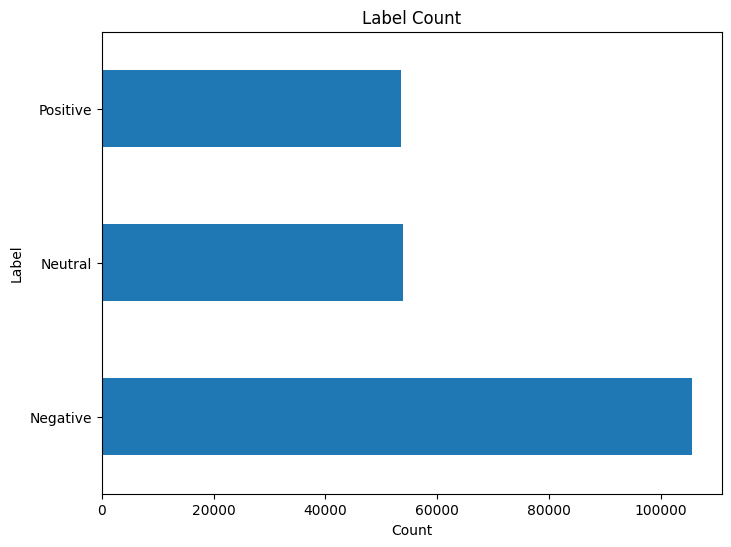

In [ ]:
pandas_df = Data.toPandas()
plt.figure(figsize=(8, 6))
label_mapping = {0: 'Negative', 1: 'Neutral', 2: "Positive"}
pandas_df['label'] = pandas_df['label'].map(label_mapping)
value_counts = pandas_df['label'].value_counts()
value_counts.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Label Count')
plt.show()

## Word Cloud

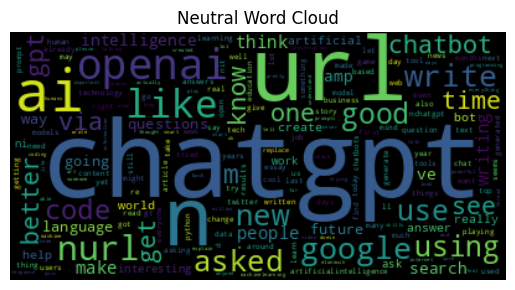

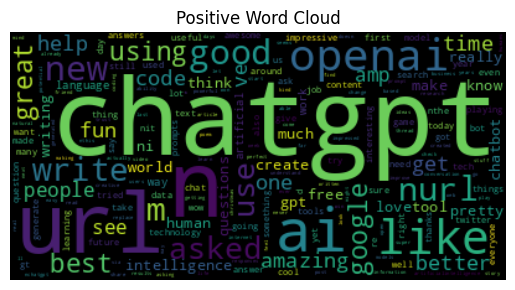

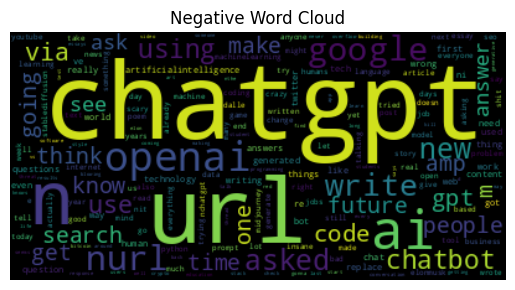

In [ ]:
# Explode the "Text" column to have one word per row
exploded_data = Data.select(explode("Text").alias("Word"), "label")

# Group the words by sentiment and count their occurrences
word_counts = exploded_data.groupBy("label", "Word").count()

# Iterate over each sentiment and create a word cloud for that sentiment
sentiments = word_counts.select("label").distinct().rdd.flatMap(lambda x: x).collect()
for sentiment in sentiments:
    words = word_counts.filter(word_counts.label == sentiment).select("Word", "count")
    word_cloud = WordCloud().generate_from_frequencies(words.rdd.map(lambda x: (x["Word"], x["count"])).collectAsMap())
    plt.figure()
    plt.imshow(word_cloud, interpolation="bilinear")
    sentiment_labels = {0: "Negative", 1: "Neutral", 2:"Positive"}
    sentiment_word = sentiment_labels[sentiment]
    plt.title(sentiment_word + " Word Cloud")
    plt.axis("off")
    plt.show()

# Machine Learning model

In [ ]:
# Split the DataFrame into training and testing sets
train_df, test_df = Data.randomSplit([0.8, 0.2], seed=42)

# Define the n-gram values and machine learning models
ngrams = [1, 2]
models = [OneVsRest(classifier = LinearSVC(maxIter = 1000)),
          LogisticRegression(family = 'multinomial', maxIter = 1000),
          NaiveBayes()]

# Create an empty list to store the pipelines
pipelines = []

# Create pipelines for each combination of n-gram and model
for ngram in ngrams:
    for model in models:
        # Define the stages of the pipeline
        stages = [
            NGram(n=ngram, inputCol="Text", outputCol="ngrams"),
            HashingTF(inputCol="ngrams", outputCol="features", numFeatures = 500000),
            IDF(inputCol="features", outputCol="tfidf_features"),
            model
        ]

        # Create the pipeline
        pipeline = Pipeline(stages=stages)

        # Train the pipeline on the training data
        model_pipeline = pipeline.fit(train_df)

        # Add the pipeline to the list
        pipelines.append(model_pipeline)

        # Evaluate the pipeline on the testing data
        predictions = model_pipeline.transform(test_df)

        # Get the predicted labels and true labels as lists
        pred_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
        true_labels = predictions.select("label").rdd.flatMap(lambda x: x).collect()

        # Print the classification report for each pipeline
        print(f"Classification report for ngram={ngram}, model={model.__class__.__name__}:")
        print(classification_report(true_labels, pred_labels))

Classification report for ngram=1, model=OneVsRest:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     21133
           1       0.71      0.59      0.65     10806
           2       0.79      0.85      0.82     10700

    accuracy                           0.82     42639
   macro avg       0.79      0.79      0.79     42639
weighted avg       0.81      0.82      0.81     42639

Classification report for ngram=1, model=LogisticRegression:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     21133
           1       0.63      0.63      0.63     10806
           2       0.78      0.79      0.78     10700

    accuracy                           0.79     42639
   macro avg       0.76      0.76      0.76     42639
weighted avg       0.79      0.79      0.79     42639

Classification report for ngram=1, model=NaiveBayes:
              precision    recall  f1-score   support

           0     

# Saving Models:

In [ ]:
Logistic_Regression = pipelines[0]
Naive_Bayes = pipelines[1]
LinearSVC = pipelines[2]

Logistic_Regression.save("Logistic_Regression")
Naive_Bayes.save("Naive_Bayes")
LinearSVC.save("LinearSVC")

In [ ]:
!zip -r /content/Logistic_Regression.zip /content/Logistic_Regression
!zip -r /content/Naive_Bayes.zip /content/Naive_Bayes
!zip -r /content/LinearSVC.zip /content/LinearSVC

  adding: content/Logistic_Regression/ (stored 0%)
  adding: content/Logistic_Regression/metadata/ (stored 0%)
  adding: content/Logistic_Regression/metadata/_SUCCESS (stored 0%)
  adding: content/Logistic_Regression/metadata/.part-00000.crc (stored 0%)
  adding: content/Logistic_Regression/metadata/part-00000 (deflated 25%)
  adding: content/Logistic_Regression/metadata/._SUCCESS.crc (stored 0%)
  adding: content/Logistic_Regression/stages/ (stored 0%)
  adding: content/Logistic_Regression/stages/2_IDF_6e5a2ac0d65a/ (stored 0%)
  adding: content/Logistic_Regression/stages/2_IDF_6e5a2ac0d65a/data/ (stored 0%)
  adding: content/Logistic_Regression/stages/2_IDF_6e5a2ac0d65a/data/part-00000-c3fadf75-6d65-489f-a064-b0361175bfc3-c000.snappy.parquet (deflated 15%)
  adding: content/Logistic_Regression/stages/2_IDF_6e5a2ac0d65a/data/_SUCCESS (stored 0%)
  adding: content/Logistic_Regression/stages/2_IDF_6e5a2ac0d65a/data/.part-00000-c3fadf75-6d65-489f-a064-b0361175bfc3-c000.snappy.parquet.crc